In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# For monitoring RAM usage.
import psutil
def print_memory_usage():
    mem = psutil.virtual_memory()
    print(f"Used: {mem.used / 1e9:.2f} GB / {mem.total / 1e9:.2f} GB")

print_memory_usage()

Used: 2.14 GB / 13.61 GB


In [5]:
# Bring the final data frame from the local drive with default RangeIndex.
from google.colab import files
uploaded = files.upload() # This opens a file picker to let you choose a file from your computer.

bert_model5k = pd.read_csv('BERT_model_5k_a.csv')
bert_model5k.info()

Saving BERT_model_5k_a.csv to BERT_model_5k_a.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4872 entries, 0 to 4871
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Chief Complaint              4871 non-null   object
 1   Discharge Diagnosis          4869 non-null   object
 2   Present Illness History      4872 non-null   object
 3   Discharge Medications        4830 non-null   object
 4   Discharge Disposition        4872 non-null   object
 5   Mental Status                4872 non-null   object
 6   Level of Consciousness       4872 non-null   object
 7   Discharge Instructions       4838 non-null   object
 8   bert_embedding_history       4872 non-null   object
 9   bert_embedding_instructions  4872 non-null   object
dtypes: object(10)
memory usage: 380.8+ KB


*DATA FORMATTING*

In [37]:
# Elements of the BERTopic expect a list of strings; verify the data type.
bert_model5k["bert_embedding_history"].dtype

dtype('O')

In [ ]:
print(bert_model5k["bert_embedding_history"].iloc[0])
print(type(bert_model5k["bert_embedding_history"].iloc[0]))

[0.025737762451171875, -0.07905974239110947, -0.28176745772361755, 0.033194057643413544, 0.10738474875688553, -0.07051364332437515, 0.02980758622288704, 0.1339935064315796, 0.13852472603321075, 0.09672482311725616, 0.21044915914535522, 0.26128914952278137, -0.016655825078487396, 0.17750070989131927, -0.030376749113202095, -0.16015516221523285, 0.1257006675004959, 0.02232024073600769, -0.10192697495222092, -0.01637040264904499, -0.14902494847774506, -0.04992733150720596, -0.4027116298675537, -0.09072853624820709, -0.17569486796855927, -0.12018916755914688, 0.05376923456788063, 0.9492096304893494, 0.11289312690496445, 0.35648512840270996, -0.012345717288553715, 0.13633134961128235, -0.2197936773300171, 0.09605241566896439, -0.021048905327916145, 0.03428145870566368, 0.06707567721605301, 0.19376756250858307, 0.07422705739736557, 0.2653104364871979, 0.12842217087745667, 0.0038167096208781004, 0.12931932508945465, 0.35690829157829285, 0.1646394431591034, -0.0139211006462574, -0.057293199002

In [6]:
# Convert string lists to real lists (BERTopic expects embeddings as a list).
bert_model5k["bert_embedding_history"] = bert_model5k["bert_embedding_history"].apply(ast.literal_eval)

# Now convert the values to a NumPy array.
embeddings = np.array(bert_model5k["bert_embedding_history"].tolist())

# Check the final shape.
print(embeddings.shape)

(4872, 768)


*PRELIMINARY AUGMENTATION OF EMBEDDINGS AND TEXT*

While a significant portion of text cleanup was handled during BERT tokenization, further enhancements were applied to improve topic modeling quality:

**1. Removal of select non-clinical high-frequency words:**
Common, non-informative words (e.g., “reports,” “noted,” “today”) were identified from the top 250 most frequent terms and removed to reduce linguistic noise and improve clustering precision.

**2.  Recognition of multi-word clinical terms:**
A custom bigram model was trained using Gensim’s phrase detection to identify and merge commonly co-occurring medical terms (e.g., “chest pain,” “shortness breath”) into single tokens. This preserves clinical meaning and supports better semantic grouping during topic modeling.

In [7]:
# Removal of select non-clinical high-frequency words:

# Ensure the column is in string format and drop any NaN
texts = bert_model5k["Present Illness History"].dropna().astype(str).tolist()

# Tokenize and clean each text entry (lowercase, remove punctuation)
all_words = []
for text in texts:
    words = re.findall(r'\b\w+\b', text.lower())  # keep only word characters
    all_words.extend(words)

# Count word frequencies
word_counts = Counter(all_words)

# Get the 250 most common words
common_words = word_counts.most_common(250)

# Convert to DataFrame for inspection
common_words_df = pd.DataFrame(common_words, columns=["word", "frequency"])

# print(common_words_df.sort_values(by="frequency", ascending=False).tail(150))

In [8]:
# Define custom stopwords list
custom_stopwords = set([
    "in", "patient", "no", "at", "history", "not", "department", "blood", "as", "mg", "right", "left", "reports", "x",
    "also", "any", "pt", "given", "per", "review", "status", "s", "l", "days", "showed", "be", "computed", "care",
    "time", "symptoms", "day", "presents", "well", "noted", "over", "notable", "since", "initial", "year", "ago",
    "started", "states", "signs", "morning", "then", "presented", "labs", "floor", "today", "found", "o", "arrival",
    "hospital", "night", "recently", "years", "further", "weeks", "present", "other", "felt", "note", "due", "r",
    "now", "week", "illness", "evaluation", "feeling", "significant", "seen", "mr", "c", "having", "imaging", "all",
    "one", "dr", "exam", "however", "few", "notes", "during", "provider", "episodes", "outside", "t", "otherwise",
    "increased", "ms", "were", "episode", "male", "months", "currently", "feels", "several", "for", "developed",
    "associated", "being", "i", "initially", "yesterday", "reported", "course", "cr", "red", "two", "very", "only",
    "went", "unit", "called", "daily", "female", "down", "within", "like", "upon", "than", "recommended", "d",
    "report", "above", "around", "with", "last", "back", "after", "systems", "disease",
    "old", "man", "worse", "referred", "prior", "more", "minutes", "hepatic", "pain", "chest",
])

# Function to remove custom stopwords
def remove_custom_stopwords(text, stopwords):
    words = re.findall(r'\b\w+\b', text.lower())  # Tokenize
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)

# Apply and save to a new column
bert_model5k["cleaned_PIH"] = bert_model5k["Present Illness History"].fillna("").apply(
    lambda x: remove_custom_stopwords(x, custom_stopwords)
)

In [ ]:
# bert_model5k["cleaned_PIH"].head(2)

In [9]:
# Use gensim's phrase detection to create bigrams with one special rule: pair verb "denies" and "denied" with one next word.

# Step 1: Tokenize text
tokenized_clean = bert_model5k["cleaned_PIH"].dropna().apply(word_tokenize)

# Step 2: Manually combine "denies" or "denied" with the next word, case-insensitive.
def pair_deny_variants(tokens):
    new_tokens = []
    i = 0
    while i < len(tokens):
        if tokens[i].lower() in ["denies", "denied"] and i + 1 < len(tokens):
            new_tokens.append(f"{tokens[i].lower()}_{tokens[i + 1].lower()}")
            i += 2  # Skip next word
        else:
            new_tokens.append(tokens[i].lower())
            i += 1
    return new_tokens

# Apply custom pairing function
tokenized_custom = tokenized_clean.apply(pair_deny_variants)

# Step 3: Train bigram model on the modified tokens
bigram_model = Phrases(tokenized_custom, min_count=25, threshold=16)
bigram_phraser = Phraser(bigram_model)

# Step 4: Apply bigram detection
bert_model5k["tokens_bigrams"] = tokenized_custom.apply(lambda x: bigram_phraser[x])

# Step 5: Reconstruct text
bert_model5k["bigrams_text"] = bert_model5k["tokens_bigrams"].apply(lambda tokens: " ".join(tokens))

In [10]:
# Preview bigram results
bert_model5k["bigrams_text"].iloc[18]

'woman hypertension_hyperlipidemia diabetes_mellitus insulin therapy cerebellar medullary stroke chronic_kidney stage_iii intravenous presenting fatigue dyspnea_exertion dyspnea_exertion markedly past dyspnea_exertion shortness_breath shortness_breath even rest tired usual respiratory issues before can_not walk stair dyspnea_exertion shortness_breath short distance unsure how long breathing improves albuterol gets husband bad cough month denies_recent_fevers chills_sweats nausea dizziness'

# **BERTopic MODEL OPTIMIZATION AND PERFORMANCE EVALUATION**

The next two code blocks accomlish two tasks:

1. Performs a parameter grid search for a BERTopic model by testing a range of parameters for the UMAP element of the model. Proceeds to the HDBSCAN element which is customized by taking normalized embeddings to leverage the Eucleadean distance calculation and by setting a min_cluster_size parameter suitable for the large, diverse clinical corpus.

2. Creates custom functions to calculate diversity and coherence scores of each tested model and applies the standard Silhouette Score calcuation from sklearn.metrics to assess the performance of the tested models.

BERTopic FOR CHEST PAIN-RELATED RECORDS ONLY

In [11]:
bert_model5k["Chief Complaint"].value_counts()
# Filter rows where 'Chief Complaint' contains the word 'chest' (case-insensitive)
chest_df = bert_model5k[bert_model5k["Chief Complaint"].str.contains(r"\bchest\b", case=False, na=False)]

# chest_df["Chief Complaint"].value_counts()
# chest_df.columns
chest_df.shape # There is a total of 342 notes related to some type of chest pain/discomfort.

(342, 13)

In [12]:
# BERTopic Model for the chest-related data set with the parameter grid search for UMAP ONLY.

# Step 1: Input data
texts_chest = chest_df["bigrams_text"].fillna("").astype(str).tolist()
embeddings_chest = normalize(np.array(chest_df["bert_embedding_history"].tolist()), norm="l2")

# Step 2: Initialize containers to store results
topic_models_chest = {}
top_words_by_model_chest = {}
topics_by_model_chest = {}

# Step 3: Define UMAP parameter grid only
neighbors_list_chest = [20, 30, 40]
components_list_chest = [3, 5, 7]
min_dist_list_chest = [0.2, 0.4, 0.6]

# Step 4: Loop through UMAP combinations (HDBSCAN is fixed)
for umap_params in product(neighbors_list_chest, components_list_chest, min_dist_list_chest):

    config_key = tuple(umap_params)
    print(f"\nTesting UMAP config: {config_key}")

    umap_model_chest = UMAP(
        n_neighbors=umap_params[0],
        n_components=umap_params[1],
        min_dist=umap_params[2],
        metric='cosine',
        random_state=42
    )

    hdbscan_model_chest = HDBSCAN(
        min_cluster_size=30,
        metric='euclidean',
        prediction_data=True,
    )

    topic_model_chest = BERTopic(
        umap_model=umap_model_chest,
        hdbscan_model=hdbscan_model_chest,
        verbose=False
    )

    try:
        topics_chest, probs_chest = topic_model_chest.fit_transform(texts_chest, embeddings_chest)
        topic_model_chest.update_topics(texts_chest, top_n_words=25)

        topic_models_chest[config_key] = topic_model_chest
        topics_by_model_chest[config_key] = topics_chest

        topic_freq_chest = topic_model_chest.get_topic_freq()
        n_topics_chest = topic_freq_chest.shape[0] - int(-1 in topic_freq_chest['Topic'].values)
        print(f"Success: {n_topics_chest} topics identified")

        topics_words_chest = {}
        for topic_id in topic_model_chest.get_topics().keys():
            if topic_id == -1:
                continue
            words_chest = topic_model_chest.get_topic(topic_id)
            top_words_chest = [word for word, _ in words_chest[:25]]
            topics_words_chest[topic_id] = top_words_chest
            print(f"\nTopic {topic_id} (Config: {config_key})")
            print(f"Top {len(top_words_chest)} words: {', '.join(top_words_chest)}")

        top_words_by_model_chest[config_key] = topics_words_chest

    except Exception as e:
        print(f"Failed for config {config_key}: {e}")

# Output variables per grid combination
# 1. topic_models_chest[config_key]
# Stores the entire trained BERTopic model for a specific config, contains the learned topics, each represented as a list of top keywords and their weights.

# 2. topics_by_model_chest[config_key]
# Stores the topic assignment list (one topic per document) for that config
# Output of fit_transform() → topics

# 3. top_words_by_model[config_key]
# Stores the top 25 words per topic in a nested dict:
# {topic_id: [word1, word2, ...]} for each config


Testing UMAP config: (20, 3, 0.2)
Success: 3 topics identified

Topic 0 (Config: (20, 3, 0.2))
Top 25 words: emergency, shortnessbreath, coronaryartery, aspirin, electrocardiogram, pressure, post, sided, dyspnea, diaphoresis, negative, rest, baseline, ray, admitted, normal, roomair, without, resolved, artery, past, worsening, chronic, admission, substernal

Topic 1 (Config: (20, 3, 0.2))
Top 25 words: encephalopathy, emergency, pressure, electrocardiogram, received, aspirin, post, admission, negative, heartrate, normal, shortnessbreath, cardiac, coronaryartery, roomair, paroxysmalnocturnal, discomfort, transferred, home, acute, without, hypertension, dyspneaorthopnea, nauseavomiting, ray

Topic 2 (Config: (20, 3, 0.2))
Top 25 words: encephalopathy, cardiaccatheterization, coronaryartery, revealed, transferred, surgery, underwent, cardiac, surgical, exertional, multivessel, artery, revascularization, hypertension, hyperlipidemia, electrocardiogram, stresstest, rest, echocardiogram, dem

In [ ]:
# To save these three Python objects (topic_models_chest, topics_by_model_chest, and top_words_by_model_chest) to the local drive from Google Colab,
# the best approach is to serialize them using pickle.

# Bundle the three dictionaries into one
chest_outputs = {
    "topic_models_chest": topic_models_chest,
    "topics_by_model_chest": topics_by_model_chest,
    "top_words_by_model_chest": top_words_by_model_chest
}

# Save to a pickle file
with open("bertopic_chest_outputs1.pkl", "wb") as f:
    pickle.dump(chest_outputs, f)

In [ ]:
# Download the saved file
files.download("bertopic_chest_outputs1.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Retrieve the output from the local drive.
with open("bertopic_chest_outputs1.pkl", "rb") as f:
  chest_outputs = pickle.load(f)

# Extract each part
topic_models_chest = chest_outputs["topic_models_chest"]
topics_by_model_chest = chest_outputs["topics_by_model_chest"]
top_words_by_model_chest = chest_outputs["top_words_by_model_chest"]

NameError: name 'chest_outputs' is not defined

In [13]:
# Performance evaluation of the UMAP grid search and saving of the top 5 configurations.

# Ensure correct input data
texts_chest = chest_df["bigrams_text"].fillna("").astype(str).tolist()
embeddings_chest = normalize(np.array(chest_df["bert_embedding_history"].tolist()), norm="l2")

# Define performance metric functions
def topic_diversity(top_n_words):
    """Calculate diversity as proportion of unique words across all topics."""
    unique_words = set()
    total_words = 0
    for words in top_n_words:
        unique_words.update(words)
        total_words += len(words)
    return len(unique_words) / total_words if total_words > 0 else 0

def topic_coherence(topics_words, texts):
    """
    Approximate coherence using co-occurrence counts in documents.
    Simpler proxy for c_npmi using log-ratio scoring.
    """
    tokenized_texts = [text.lower().split() for text in texts]
    doc_word_sets = [set(doc) for doc in tokenized_texts]

    coherence_scores = []

    for topic in topics_words:
        if len(topic) < 2:
            coherence_scores.append(0)
            continue

        score = 0
        count = 0

        for i in range(len(topic)):
            for j in range(i + 1, len(topic)):
                w1, w2 = topic[i], topic[j]
                co_occurs = sum((w1 in doc and w2 in doc) for doc in doc_word_sets)
                occurs_w2 = sum((w2 in doc) for doc in doc_word_sets)

                if occurs_w2 > 0:
                    score += np.log((co_occurs + 1) / occurs_w2)
                count += 1

        coherence_scores.append(score / count if count > 0 else 0)

    return np.mean(coherence_scores)

# Evaluation loop
results_chest = []
top_n_word_chest = 25

for config, model in topic_models_chest.items():
    try:
        topic_freq_chest = model.get_topic_freq()
        n_topics_chest = topic_freq_chest.shape[0] - int(-1 in topic_freq_chest['Topic'].values)

        # Extract top N words per topic
        topics_words_chest = [
            [word for word, _ in model.get_topic(topic)[:top_n_word_chest]]
            for topic in model.get_topics().keys()
            if topic != -1
        ]

        coherence_chest = topic_coherence(topics_words_chest, texts_chest)
        diversity_chest = topic_diversity(topics_words_chest)

        # UMAP projection & topic labels
        umap_model_chest = model.umap_model
        reduced_embeddings_chest = umap_model_chest.transform(embeddings_chest)
        topics_chest = topics_by_model_chest[config]

        valid_indices_chest = [i for i, t in enumerate(topics_chest) if t != -1]
        filtered_embeddings_chest = [reduced_embeddings_chest[i] for i in valid_indices_chest]
        filtered_labels_chest = [topics_chest[i] for i in valid_indices_chest]

        if len(set(filtered_labels_chest)) > 1:
            silhouette_chest = silhouette_score(filtered_embeddings_chest, filtered_labels_chest)
        else:
            silhouette_chest = None

        results_chest.append({
            "Configurations (chest-related)": config,
            "Number of topics identified (chest-related)": n_topics_chest,
            "Coherence score (chest-related)": coherence_chest,
            "Diversity score (chest-related)": diversity_chest,
            "Silhouette Score (chest-related)": silhouette_chest
        })



    except Exception as e:
        print(f"Skipping model {config} due to error: {e}")

valid_silhouette_results = [entry for entry in results_chest if entry["Silhouette Score (chest-related)"] is not None]

# Sort remaining entries by silhouette score
sorted_results_chest = sorted(
    valid_silhouette_results,
    key=lambda x: x["Silhouette Score (chest-related)"],
    reverse=True
)

# Extract top 5 configurations based on coherence
top_configs = [entry["Configurations (chest-related)"] for entry in sorted_results_chest[:5]]

# You can then use top_configs downstream for:
# Word heatmap
# Visual comparison
# Further evaluation
top_configs

# Data needed for performance evaluation (grid search output):
# texts_chest: Clinical text (final column)
# embeddings_chest: Precomputed BERT embeddings (normalized)
# topics_by_model_chest: Topic assignments per document for each config
# topic_models_chest: Trained BERTopic models (with fitted UMAP+HDBSCAN)
# model.get_topic_freq(): Gives a list of topic IDs and frequencies
# model.get_topic(topic_id): Returns top words and scores per topic

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[(20, 3, 0.2), (30, 3, 0.2), (20, 3, 0.4), (40, 5, 0.2), (20, 5, 0.2)]

In [14]:
model_perf_results_chest = pd.DataFrame(results_chest)
model_perf_results_chest.sort_values(by="Silhouette Score (chest-related)", ascending=False)

,Configurations (chest-related),Number of topics identified (chest-related),Coherence score (chest-related),Diversity score (chest-related),Silhouette Score (chest-related)
0,"(20, 3, 0.2)",3,-1.206056,0.720000,0.648965
9,"(30, 3, 0.2)",3,-1.265653,0.720000,0.638491
1,"(20, 3, 0.4)",2,-1.058357,0.800000,0.632276
21,"(40, 5, 0.2)",3,-1.256629,0.746667,0.630600
3,"(20, 5, 0.2)",3,-1.190356,0.733333,0.617640
12,"(30, 5, 0.2)",3,-1.312253,0.760000,0.605073
18,"(40, 3, 0.2)",2,-1.345077,0.760000,0.598636
2,"(20, 3, 0.6)",2,-1.292751,0.720000,0.595522
4,"(20, 5, 0.4)",2,-1.289764,0.740000,0.589498
6,"(20, 7, 0.2)",2,-1.430027,0.760000,0.584799


In [ ]:
# Save the performance file to the local drive for faster access
model_perf_results_chest.to_csv('model_perf_results_chest_use.csv', index=False)

from google.colab import files
files.download('model_perf_results_chest_use.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Bring the final data frame from the local drive with default RangeIndex.
uploaded = files.upload() # This opens a file picker to let you choose a file from your computer.

perf_eval_chest = pd.read_csv('model_perf_results_chest_use.csv')
# perf_eval_chest

Saving model_perf_results_chest_use.csv to model_perf_results_chest_use.csv


*CHECK BEST CONFIGURATION RESULTS*

In [ ]:
# Top words per topic per configuration
for config, model in topic_models_chest.items():
    print(f"\n=== Model Config: {config} ===")
    topics_chest = model.get_topics()

    for topic_id, topic_words in topics_chest.items():
        if topic_id == -1:
            continue  # Skip outlier topic
        top_words_chest = [word for word, _ in topic_words]
        print(f"Topic {topic_id}: {', '.join(top_words_chest)}")


=== Model Config: (20, 3, 0.2) ===
Topic 0: emergency, shortnessbreath, coronaryartery, aspirin, electrocardiogram, pressure, post, sided, dyspnea, diaphoresis, negative, rest, baseline, ray, admitted, normal, roomair, without, resolved, artery, past, worsening, chronic, admission, substernal
Topic 1: encephalopathy, emergency, pressure, electrocardiogram, received, aspirin, post, admission, negative, heartrate, normal, shortnessbreath, cardiac, coronaryartery, roomair, paroxysmalnocturnal, discomfort, transferred, home, acute, without, hypertension, dyspneaorthopnea, nauseavomiting, ray
Topic 2: encephalopathy, cardiaccatheterization, coronaryartery, revealed, transferred, surgery, underwent, cardiac, surgical, exertional, multivessel, artery, revascularization, hypertension, hyperlipidemia, electrocardiogram, stresstest, rest, echocardiogram, demonstrated, myocardialinfarction, anteriordescending, three, diabetesmellitus, bypassgraft

=== Model Config: (20, 3, 0.4) ===
Topic 0: emer

In [15]:
# Best configuration
best_config = (20, 3, 0.2)

# Retrieve from stored results
best_model = topic_models_chest[best_config]
best_topics = topics_by_model_chest[best_config]
best_top_words = top_words_by_model_chest[best_config]

# Build list of top words per document
top_words_per_doc = []

for topic in best_topics:
    if topic == -1:
        top_words_per_doc.append("Outlier Topic")
    else:
        words = best_top_words.get(topic, [])
        top_words_per_doc.append(", ".join(words[:25]))  # capture top 25 words

# Add column to chest_df
chest_df["Top Topic Words"] = top_words_per_doc

In [ ]:
# Check the results
chest_df["Top Topic Words"].unique()

array(['emergency, shortnessbreath, coronaryartery, aspirin, electrocardiogram, pressure, post, sided, dyspnea, diaphoresis, negative, rest, baseline, ray, admitted, normal, roomair, without, resolved, artery, past, worsening, chronic, admission, substernal',
       'Outlier Topic',
       'encephalopathy, emergency, pressure, electrocardiogram, received, aspirin, post, admission, negative, heartrate, normal, shortnessbreath, cardiac, coronaryartery, roomair, paroxysmalnocturnal, discomfort, transferred, home, acute, without, hypertension, dyspneaorthopnea, nauseavomiting, ray',
       'encephalopathy, cardiaccatheterization, coronaryartery, revealed, transferred, surgery, underwent, cardiac, surgical, exertional, multivessel, artery, revascularization, hypertension, hyperlipidemia, electrocardiogram, stresstest, rest, echocardiogram, demonstrated, myocardialinfarction, anteriordescending, three, diabetesmellitus, bypassgraft'],
      dtype=object)

*VISUALIZATION OF RESULTS*

It's important to visualize and compare model configurations in ways that demonstrate:
- Model quality (e.g., topic coherence, number of topics, topic diversity).
- Model structure (e.g., how topics cluster, overlap, or evolve).

In [ ]:
# How many topics are generated per model (i.e., each UMAP configuration)?

# Define color map for topics
color_map = {
    "Topic 0": "#0DE3E3",  # Blue
    "Topic 1": "#EDE91E",  # Yellow
    "Topic 2": "#1FD55C",  # Green
    "Topic 3": "#D65CFF",  # Purple
    "Topic 4": "#FF8C00",  # Orange
    "Topic 5": "#8A2BE2"   # Violet
}

# Use top_configs
configs_to_show = top_configs  # [(20, 3, 0.2), (30, 3, 0.2), (20, 3, 0.4), (40, 5, 0.2), (20, 5, 0.2)]

# Collect all unique topic labels (exlcuding outlier)
all_topic_labels = set()
for cfg in configs_to_show:
    topic_ids = [f"Topic {t}" for t in set(topics_by_model_chest[cfg]) if t != -1]
    all_topic_labels.update(topic_ids)
sorted_topic_labels = sorted(all_topic_labels, key=lambda x: int(x.split()[1]))

# Initialize figure
fig = go.Figure(
    layout=go.Layout(
        title=dict(
            text="<b>Distribution of Notes per Topic | Animated by UMAP Configuration</b>",
            y=0.95,
            x=0.5,
            xanchor='center',
            yanchor='top',
            font=dict(size=18, family="Arial", color="black")
        ),
        annotations=[
            dict(
                text=(
                    "<span style='font-weight: bold; font-size: 14px; color: #8A2BE2;'>"
                    "This chart displays the number of notes clustered per topic for each 3-way UMAP configuration:</span><br>"
                    "1. How many nearby notes each note should consider when reducing the data to lower dimensions.<br>"
                    "2. How many dimensions the data should be reduced to (e.g., 3 = a 3D map).<br>"
                    "3. How tightly similar notes should be placed together (smaller values keep clusters more compact)."
                ),
                xref="paper",
                yref="paper",
                x=0.8,
                y=1.1,
                xanchor="center",
                showarrow=False,
                align="left",
                font=dict(size=12)
            )
        ],
        xaxis=dict(
            title="Topic ID (exludes outlier)",
            categoryorder='array',
            categoryarray=sorted_topic_labels,
            linecolor='black',
            showgrid=False
        ),
        yaxis=dict(
            title="Number of Notes",
            linecolor='black',
            showgrid=False
        ),
        plot_bgcolor='white',
        paper_bgcolor='white',
        updatemenus=[
            dict(
                 type="buttons",
                 showactive=True,
                 x=0.05,
                y=1.2,
                xanchor="left",
                yanchor="top",
                direction="left",
                buttons=[dict(
                label="▶ PLAY",
                method="animate",
                args=[None, {
                "frame": {"duration": 2000, "redraw": True},
                "fromcurrent": True,
                "transition": {"duration": 300, "easing": "linear"}
                }],
                args2=[None, {
                "mode": "immediate",
                "frame": {"duration": 0, "redraw": False},
                "transition": {"duration": 0}
                }]
        )],
        bgcolor="rgba(138, 43, 226, 0.9)",  # Semi-transparent violet
        bordercolor="black",
        borderwidth=1,
        pad=dict(r=10, t=8, b=8, l=10),
        font=dict(color="#8A2BE2", size=14, family="Arial Black")
        )
      ]
    )
)

# Add initial bar trace
initial_cfg = configs_to_show[0]
initial_counts = Counter([t for t in topics_by_model_chest[initial_cfg] if t != -1])
y_init = [initial_counts.get(int(label.split()[1]), 0) for label in sorted_topic_labels]
colors_init = [color_map.get(label, "#CCCCCC") for label in sorted_topic_labels]

fig.add_trace(go.Bar(
    x=sorted_topic_labels,
    y=y_init,
    marker_color=colors_init,
    text=y_init,
    textposition="inside",
    insidetextanchor="middle"
))

# Create animation frames
frames = []
for cfg in configs_to_show:
    counts = Counter([t for t in topics_by_model_chest[cfg] if t != -1])
    y_vals = [counts.get(int(label.split()[1]), 0) for label in sorted_topic_labels]
    bar_colors = [color_map.get(label, "#CCCCCC") for label in sorted_topic_labels]

    frames.append(go.Frame(
        data=[go.Bar(
            x=sorted_topic_labels,
            y=y_vals,
            marker_color=bar_colors,
            text=y_vals,
            textposition="inside"
        )],
        name=str(cfg),
        layout=go.Layout(title_text=f"<b>Distribution of Notes per Topic - Config: {cfg}</b>")
    ))

fig.frames = frames
fig.show()

# Save and download to the local drive (for video recording)
fig.write_html("topic_distribution_animation.html")
files.download("topic_distribution_animation.html")

# If you want to share this interactive chart via a link, you can upload the HTML file to:
# GitHub Pages
# Netlify (free account)
# Google Drive (public sharing enabled)
# your portfolio or company website

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# How do Diversity and Silhouette scores relate?

# Prepare data using only top_configs
top10 = model_perf_results_chest[
    model_perf_results_chest["Configurations (chest-related)"].isin(top_configs)
].sort_values(
    by="Silhouette Score (chest-related)", ascending=False
).copy()

top10.reset_index(drop=True, inplace=True)
top10["Rank"] = top10.index + 1
top10["Configuration"] = top10["Configurations (chest-related)"]

# Initialize animated figure
fig = go.Figure(
    layout=go.Layout(
        title=dict(
            text="<b>Silhouette Scores vs. Diversity Scores | Animated by UMAP Configuration</b>",
            y=0.95,
            x=0.5,
            xanchor='center',
            yanchor='top',
            font=dict(size=18, family="Arial", color="black")
        ),
        annotations=[dict(
            text=(
                "<span style='font-weight: bold; font-size: 14px; color: #8A2BE2;'>"
                "This chart displays how the Silhouette scores and Diversity scores change across the selected 3-factor UMAP configurations:</span><br>"
                "1. Silhouette scores measure the degree of topic separation.<br>"
                "2. Diversity scores measure the uniqueness of word collections in each topic."
            ),
            xref="paper",
            yref="paper",
            x=0.8,
            y=1.12,
            xanchor="center",
            showarrow=False,
            align="left",
            font=dict(size=12)
        )],
        xaxis=dict(
            title="Diversity Score",
            range=[0, 1],
            linecolor='black',
            showgrid=True,
            gridcolor='lightgray',
            gridwidth=0.5
        ),
        yaxis=dict(
            title="Silhouette Score",
            range=[0, 1],
            linecolor='black',
            showgrid=True,
            gridcolor='lightgray',
            gridwidth=0.5
        ),
        plot_bgcolor='white',
        paper_bgcolor='white',
        updatemenus=[dict(
            type="buttons",
            showactive=True,
            x=0.05,
            y=1.2,
            xanchor="left",
            yanchor="top",
            direction="left",
            buttons=[dict(
                label="▶ PLAY",
                method="animate",
                args=[None, {
                    "frame": {"duration": 2000, "redraw": True},
                    "fromcurrent": True,
                    "transition": {"duration": 300, "easing": "linear"}
                }]
            )],
            bgcolor="rgba(138, 43, 226, 0.9)",  # Styled HERE instead
            bordercolor="black",
            borderwidth=1,
            pad=dict(r=10, t=8, b=8, l=10),
            font=dict(color="#8A2BE2", size=14, family="Arial Black")
        )]
    )
)

# Initial frame
fig.add_trace(go.Scatter(
    x=[top10["Diversity score (chest-related)"][0]],
    y=[top10["Silhouette Score (chest-related)"][0]],
    mode="markers+text",
    marker=dict(size=50, color="#0DE3E3"),
    text=[top10["Configuration"][0]],
    textposition="top center",
    textfont=dict(size=12, family="Arial", color="black")
))

# Animation frames
frames = []
for i, row in top10.iterrows():
    frames.append(go.Frame(
        data=[go.Scatter(
            x=[row["Diversity score (chest-related)"]],
            y=[row["Silhouette Score (chest-related)"]],
            mode="markers+text",
            marker=dict(size=50, color="#0DE3E3"),
            text=[row["Configuration"]],
            textposition="top center",
            textfont=dict(size=12, family="Arial", color="black")
        )],
        name=f"Rank {row['Rank']}",
        layout=go.Layout(
            title_text=f"<b>Configuration Rank {row['Rank']}: {row['Configuration']}</b>"
        )
    ))

fig.frames = frames
fig.show()


# Save and download to the local drive (for video recording)
fig.write_html("diversity_silhouette_animation.html")
files.download("diversity_silhouette_animation.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

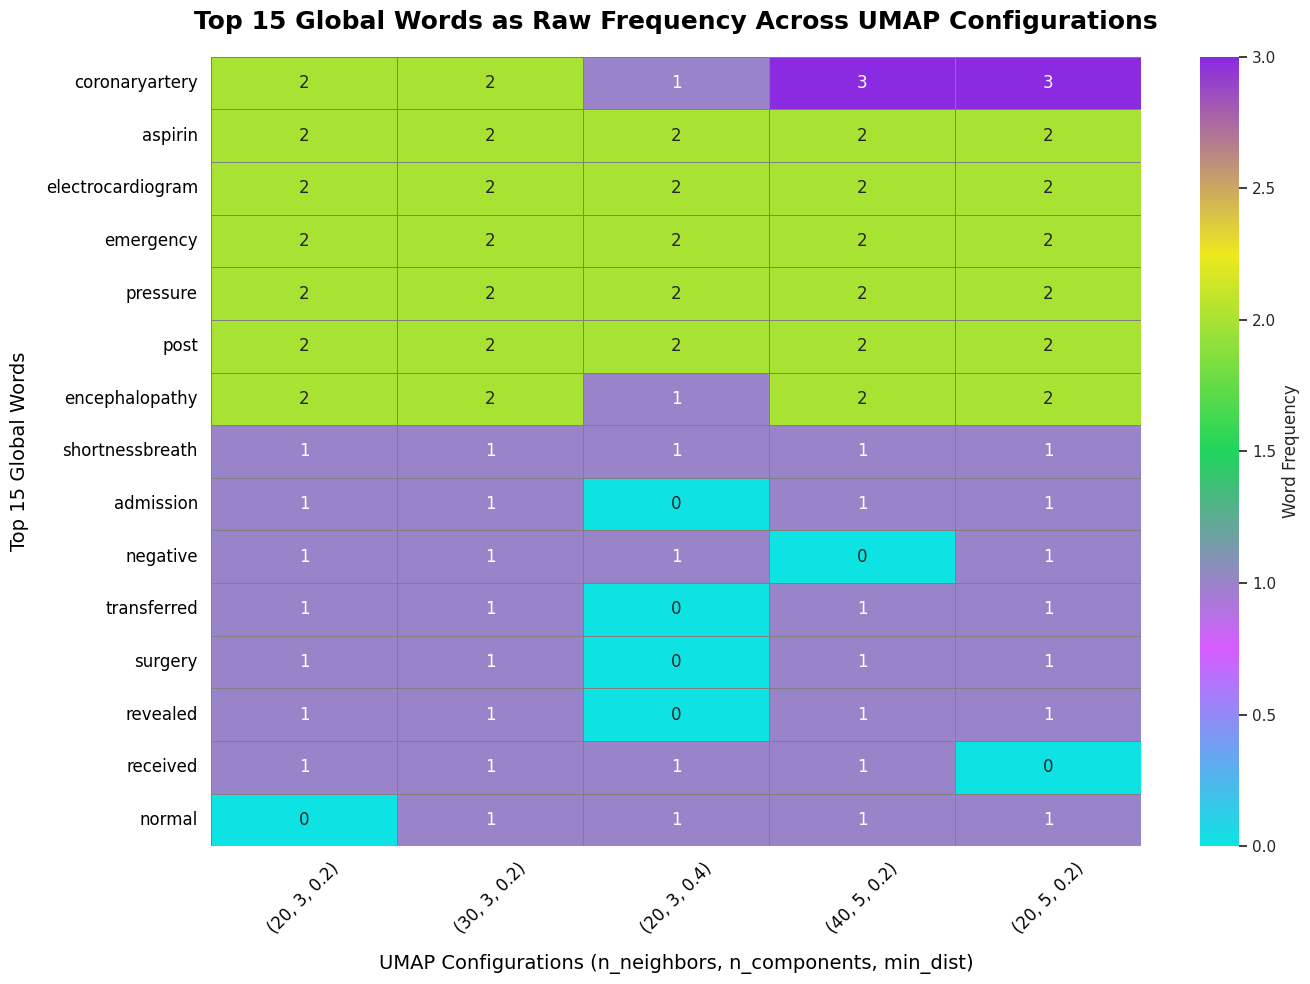

In [ ]:
# Raw counts of the globally dominant words in each configuration.

# Step 1: Custom color palette
color_map = {
    "Topic 0": "#0DE3E3",  # Blue
    "Topic 1": "#D65CFF",  # Purple
    "Topic 2": "#1FD55C",  # Green
    "Topic 3": "#EDE91E",  # Yellow
    "Topic 4": "#8A2BE2"   # Violet
}
custom_cmap = LinearSegmentedColormap.from_list("tropical", list(color_map.values()))

# Step 2: Parameters
top_n_words_per_topic = 10

# Step 3: Collect word frequencies from top configurations
word_freq_by_config = defaultdict(lambda: Counter())

for cfg in top_configs:
    model = topic_models_chest[cfg]
    topics = model.get_topics()

    for topic_id, word_list in topics.items():
        if topic_id == -1:
            continue
        top_words = [word for word, _ in word_list[:top_n_words_per_topic]]
        word_freq_by_config[cfg].update(top_words)

# Step 4: Build heatmap DataFrame
all_top_words = set()
for cfg in word_freq_by_config:
    all_top_words.update(word_freq_by_config[cfg].keys())

heatmap_df = pd.DataFrame(index=sorted(all_top_words), columns=[str(cfg) for cfg in top_configs])
heatmap_df = heatmap_df.fillna(0)

for cfg in top_configs:
    for word, count in word_freq_by_config[cfg].items():
        heatmap_df.loc[word, str(cfg)] = count

# Step 5: Trim to top 15 global words
# Sums word counts across all configurations.
# Selects the top 15 globally most frequent words.

top_global_words = heatmap_df.sum(axis=1).sort_values(ascending=False).head(15).index
heatmap_raw_count_ind = heatmap_df.loc[top_global_words]  # renamed final output

# Step 6: Plot heatmap using custom colormap
plt.figure(figsize=(14, 10))
sns.set(style="whitegrid")

ax = sns.heatmap(
    heatmap_raw_count_ind,
    cmap=custom_cmap,
    linewidths=0.5,
    linecolor='gray',
    annot=True,
    fmt='g',
    cbar_kws={'label': 'Word Frequency'},
    square=False
)

# Step 7: Style and annotate
plt.title("Top 15 Global Words as Raw Frequency Across UMAP Configurations", fontsize=18, fontweight='bold', pad=20, color='black', loc='center')
plt.xlabel("UMAP Configurations (n_neighbors, n_components, min_dist)", fontsize=14, labelpad=12, color='black')
plt.ylabel("Top 15 Global Words", fontsize=14, labelpad=12, color='black')

ax.tick_params(axis='x', labelsize=12, colors='black', rotation=45)
ax.tick_params(axis='y', labelsize=12, colors='black')

plt.tight_layout()
plt.show()


Here, we see the list of 15 globally dominant words (aggregated from all the models of all the configurations). Thus, for the raw count of unique words and preserved bi-phrases, we observe that a few dominant terms like "aspirin" and "emergency" appear twice among the top topic words in the best-performing UMAP configuration (n_neighbors = 20, n_components = 3, min_dist = 0.2).

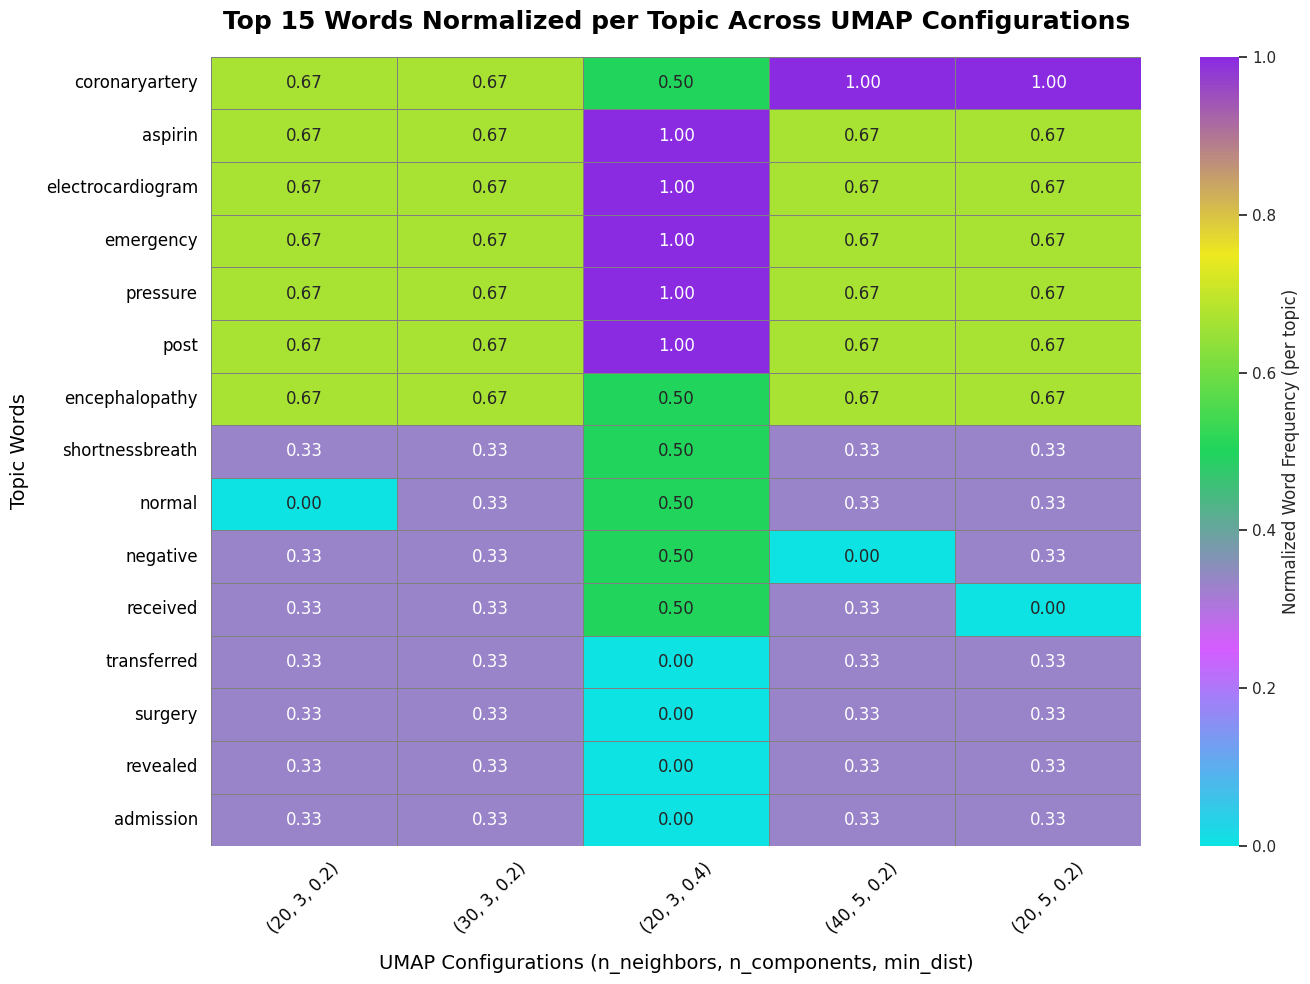

In [ ]:
# Normalizing by topic: Taking the raw count of how many topics (excluding outliers) each word appears in (among the top N topic words),
# and then dividing that by the number of topics in the configuration.

# Step 1: Custom color palette from your color_map
color_map = {
    "Topic 0": "#0DE3E3",  # Blue
    "Topic 1": "#D65CFF",  # Purple
    "Topic 2": "#1FD55C",  # Green
    "Topic 3": "#EDE91E",  # Yellow
    "Topic 4": "#8A2BE2"   # Violet
}
custom_cmap = LinearSegmentedColormap.from_list("tropical", list(color_map.values()))

# Step 2: Parameters
top_n_words_per_topic = 10

# Step 3: Collect normalized word frequencies from top configurations
word_freq_by_config = defaultdict(lambda: Counter())

for cfg in top_configs:
    model = topic_models_chest[cfg]
    topics = model.get_topics()

    # Count non-outlier topics for normalization
    num_topics = sum(1 for topic_id in topics if topic_id != -1)

    word_counts = Counter()
    for topic_id, word_list in topics.items():
        if topic_id == -1:
            continue
        top_words = [word for word, _ in word_list[:top_n_words_per_topic]]
        word_counts.update(top_words)

    # Normalize word counts by number of topics
    for word, count in word_counts.items():
        word_freq_by_config[cfg][word] = count / num_topics

# Step 4: Build heatmap DataFrame
all_top_words = set()
for cfg in word_freq_by_config:
    all_top_words.update(word_freq_by_config[cfg].keys())

heatmap_df = pd.DataFrame(index=sorted(all_top_words), columns=[str(cfg) for cfg in top_configs])
heatmap_df = heatmap_df.fillna(0)

for cfg in top_configs:
    for word, norm_count in word_freq_by_config[cfg].items():
        heatmap_df.loc[word, str(cfg)] = norm_count

# Step 5: Trim to top 15 global words by normalized sum
top_global_words = heatmap_df.sum(axis=1).sort_values(ascending=False).head(15).index
heatmap_df_trimmed = heatmap_df.loc[top_global_words]

# save the final normalized-by-topic heatmap data ---
heatmap_norm_topic_ind = heatmap_df_trimmed.copy()

# Step 6: Plot heatmap using custom colormap
plt.figure(figsize=(14, 10))
sns.set(style="whitegrid")

ax = sns.heatmap(
    heatmap_norm_topic_ind,
    cmap=custom_cmap,
    linewidths=0.5,
    linecolor='gray',
    annot=True,
    fmt='.2f',
    cbar_kws={'label': 'Normalized Word Frequency (per topic)'},
    square=False
)

# Step 7: Style and annotate
plt.title("Top 15 Words Normalized per Topic Across UMAP Configurations", fontsize=18, fontweight='bold', pad=20, color='black', loc='center')
plt.xlabel("UMAP Configurations (n_neighbors, n_components, min_dist)", fontsize=14, labelpad=12, color='black')
plt.ylabel("Topic Words", fontsize=14, labelpad=12, color='black')

ax.tick_params(axis='x', labelsize=12, colors='black', rotation=45)
ax.tick_params(axis='y', labelsize=12, colors='black')

plt.tight_layout()
plt.show()

Here, we display the 15 globally dominant words based on their normalized frequency across topics (i.e., how often each word appears among the top topic words, adjusted for the number of topics in each configuration). This allows us to identify terms such as "aspirin", "emergency", and "coronary artery" that consistently appear across the topics of multiple models, highlighting their generality rather than topic specificity.

*FREQUENCY VS DISTINCTIVENESS: CRITICAL ELEMENT FOR TOPIC MODELING*

c-TF-IDF adjusts a word’s importance based on how unique it is to a particular topic relative to all other topics. It helps to identify words that contribute to topic distinctiveness.
As shown in the prevous results, frequent words like “aspirin” or “emergency” may appear often across all topics, therefore c-TF-IDF would downweight them accordingly.

Procedure:
1. Group documents by topic (based on predicted labels from each model).
2. Concatenate all documents in each topic into a single text per topic.
3. Compute c-TF-IDF for each word per topic.
4. Select top-n words per topic based on c-TF-IDF, not frequency.
5. Plot heatmaps using c-TF-IDF scores.

In [ ]:
# To find differentiating words, apply c-TF-IDF to the corpus grouped by topic,
# and re-rank words by c-TF-IDF score within each topic.

# Inputs
best_config = (20, 3, 0.2)
best_model = topic_models_chest[best_config]
best_topics = topics_by_model_chest[best_config]
texts = chest_df["bigrams_text"].fillna("").astype(str).tolist()

print("\nBest Model:", best_model)
print("Number of topics in best model:", len(best_model.get_topics()))


Best Model: BERTopic(calculate_probabilities=False, ctfidf_model=ClassTfidfTransformer(...), embedding_model=None, hdbscan_model=HDBSCAN(...), language=english, low_memory=False, min_topic_size=10, n_gram_range=(1, 1), nr_topics=None, representation_model=None, seed_topic_list=None, top_n_words=25, umap_model=UMAP(...), vectorizer_model=CountVectorizer(...), verbose=False)
Number of topics in best model: 4


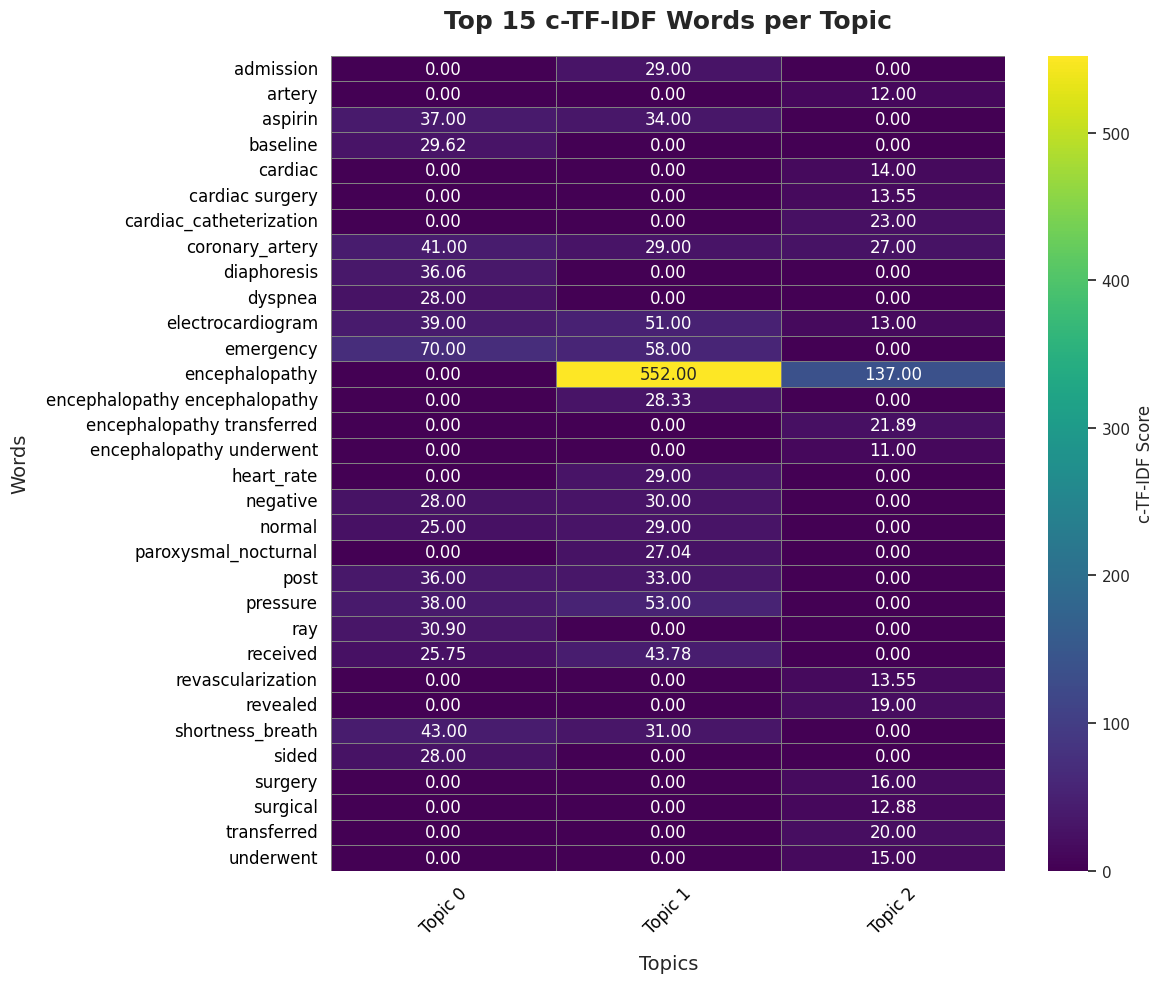

In [ ]:
# Step 1: Filter out outlier topics
chest_df_valid = chest_df.copy()
chest_df_valid["Topic"] = best_topics
chest_df_valid = chest_df_valid[chest_df_valid["Topic"] != -1]

# Step 2: Concatenate text by topic
docs_per_topic = chest_df_valid.groupby("Topic")["bigrams_text"].apply(lambda x: " ".join(x)).reset_index()

# Step 3: TF and IDF calculation
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
X_counts = vectorizer.fit_transform(docs_per_topic["bigrams_text"])
feature_names = vectorizer.get_feature_names_out()

transformer = TfidfTransformer(norm=None, use_idf=True, smooth_idf=True, sublinear_tf=False)
X_ctfidf = transformer.fit_transform(X_counts)

# Step 4: Create DataFrame with c-TF-IDF scores
ctfidf_df = pd.DataFrame(
    X_ctfidf.toarray(),
    index=[f"Topic {i}" for i in docs_per_topic["Topic"]],
    columns=feature_names
)

# Step 5: Select top 15 words per topic
top_n = 15
top_words_per_topic = {}
for topic in ctfidf_df.index:
    top_words = ctfidf_df.loc[topic].sort_values(ascending=False).head(top_n)
    top_words_per_topic[topic] = top_words

# Step 6: Build combined DataFrame of all top words
unique_words = sorted(set(word for topic_words in top_words_per_topic.values() for word in topic_words.index))
ctfidf_top_df = pd.DataFrame(index=unique_words, columns=ctfidf_df.index)

for topic in ctfidf_df.index:
    for word in unique_words:
        ctfidf_top_df.loc[word, topic] = top_words_per_topic[topic].get(word, 0)

ctfidf_top_df = ctfidf_top_df.fillna(0).astype(float)

# Step 7: Plot static heatmap
plt.figure(figsize=(12, 10))
sns.set(style="whitegrid")

ax = sns.heatmap(
    ctfidf_top_df,
    cmap="viridis",
    linewidths=0.5,
    linecolor='gray',
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'c-TF-IDF Score'},
    square=False
)

plt.title("Top 15 c-TF-IDF Words per Topic", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Topics", fontsize=14, labelpad=12)
plt.ylabel("Words", fontsize=14, labelpad=12)

ax.tick_params(axis='x', labelsize=12, colors='black', rotation=45)
ax.tick_params(axis='y', labelsize=12, colors='black')

plt.tight_layout()
plt.show()

The c-TF-IDF scores are calculated relative to the full class corpus (i.e., all concatenated documents for each topic) and the complete vocabulary across all topics.

The heatmap is scaled according to the minimum and maximum values in the full ctfidf_top_df (top 15 words). A higher score indicates that a term is not only frequent within a specific topic but also rare across other topics, thus capturing topical specificity.

In this example, the term "encephalopathy" has an exceptionally high score (552.00) in Topic 1 and near-zero scores for the other two topics. This introduces skewness in the distribution of the scores but also highlights the term as a strong signal term, highly representative of Topic 1 and uncommon in the other themes.

In contrast, more generic terms like "aspirin" or "emergency" appear across multiple topics and are assigned lower c-TF-IDF scores due to their broader presence.

Overall, c-TF-IDF is a powerful method for identifying differentiating topic terms, offering deeper insight than frequency alone. It effectively captures the distinction between generic and topic-specific vocabulary.

In [ ]:
# Filter chest_df to show only notes assigned to Topic 1
topic_1_notes = chest_df[np.array(best_topics) == 1]

# Display relevant columns to explore
topic_1_notes[["Present Illness History", "bigrams_text"]].head(10)
topic_1_notes.info()


<class 'pandas.core.frame.DataFrame'>
Index: 43 entries, 93 to 4827
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Chief Complaint              43 non-null     object
 1   Discharge Diagnosis          43 non-null     object
 2   Present Illness History      43 non-null     object
 3   Discharge Medications        43 non-null     object
 4   Discharge Disposition        43 non-null     object
 5   Mental Status                43 non-null     object
 6   Level of Consciousness       43 non-null     object
 7   Discharge Instructions       43 non-null     object
 8   bert_embedding_history       43 non-null     object
 9   bert_embedding_instructions  43 non-null     object
 10  cleaned_PIH                  43 non-null     object
 11  tokens_bigrams               43 non-null     object
 12  bigrams_text                 43 non-null     object
 13  Top Topic Words              43 non-nul

A follow-up on the 43 discharge notes assigned to Topic 1 reveals a pattern of lengthy narratives dominated by the condition called hepatic encephalopathy, typically secondary to advanced liver disease. This term emerges as a strong signal in the topic but also causes other c-TF-IDF scores to appear disproportinately low. A logical next step would be to consult a subject matter expert (e.g., attending physicians) to explore strategies for managing the influence of such dominant terms in topic modeling. Potential mitigation approaches might include term weighting adjustments, custom stopword inclusion, or modeling strategies that downplay repetitive clinical conditions.

Options to manage frequent words (differentiating between informative and non-informative terms)
1. Custom stopword list:
Add "hepatic encephalopathy" to a custom stopword list if it's clinically uninformative for your modeling goal (e.g., distinguishing topics beyond liver-related diagnoses).

2. Term frequency capping:
Set a max document frequency threshold in your vectorizer to exclude overly common terms within a topic (even if rare globally).

3. Topic merging or splitting:
If Topic 1 is dominated by a single condition, it may reflect a sub-cohort worth isolating or modeling separately.

4. TF normalization:
Apply sublinear TF scaling or normalize document lengths to reduce the weight of long clinical notes.

5. Stratify modeling:
Model notes with certain ICD codes (e.g., liver disease) separately to reduce the dominance of systemically repeated terms.

# **APPENDIX**

In [ ]:
# BERTopic Model for the chest-related data set with the parameter grid search for UMAP AND HDBSCAN.

# Step 1: Input data
texts_chest = chest_df["bigrams_text"].fillna("").astype(str).tolist()
embeddings_chest = normalize(np.array(chest_df["bert_embedding_history"].tolist()), norm="l2")

# Step 2: Initialize containers to store results
topic_models_chest = {}
top_words_by_model_chest = {}
topics_by_model_chest = {}

# Step 3: Define parameter grids
# UMAP
neighbors_list_chest = [20, 30, 40]
components_list_chest = [3, 5, 8]
min_dist_list_chest = [0.2, 0.4, 0.6]
# HDBSCAN
min_cluster_size_list_chest = [10, 20, 30]
min_samples_list_chest = [10, 20, 30]
cluster_selection_epsilon_list_chest = [0.1, 0.2, 0.3]
alpha_list_chest = [0.5, 1.0, 1.5]

# Step 4: Loop through combinations
for umap_params in product(neighbors_list_chest, components_list_chest, min_dist_list_chest):
    for hdbscan_params in product(min_cluster_size_list_chest, min_samples_list_chest, cluster_selection_epsilon_list_chest, alpha_list_chest):

        config_key = (*umap_params, *hdbscan_params)
        print(f"\nTesting config: {config_key}")

        umap_model_chest = UMAP(
            n_neighbors=umap_params[0],
            n_components=umap_params[1],
            min_dist=umap_params[2],
            metric='cosine',
            random_state=42
        )

        hdbscan_model_chest = HDBSCAN(
            min_cluster_size=hdbscan_params[0],
            min_samples=hdbscan_params[1],
            cluster_selection_epsilon=hdbscan_params[2],
            alpha=hdbscan_params[3],
            metric='euclidean',
            prediction_data=True,
            algorithm="best",
            allow_single_cluster=False
        )

        topic_model_chest = BERTopic(
            umap_model=umap_model_chest,
            hdbscan_model=hdbscan_model_chest,
            verbose=False
        )

        try:
            topics_chest, probs_chest = topic_model_chest.fit_transform(texts_chest, embeddings_chest)
            topic_model_chest.update_topics(texts_chest, top_n_words=25)

            topic_models_chest[config_key] = topic_model_chest
            topics_by_model_chest[config_key] = topics_chest

            topic_freq_chest = topic_model_chest.get_topic_freq()
            n_topics_chest = topic_freq_chest.shape[0] - int(-1 in topic_freq_chest['Topic'].values)
            print(f"Success: {n_topics_chest} topics identified")

            topics_words_chest = {}
            for topic_id in topic_model_chest.get_topics().keys():
                if topic_id == -1:
                    continue
                words_chest = topic_model_chest.get_topic(topic_id)
                top_words_chest = [word for word, _ in words_chest[:25]]
                topics_words_chest[topic_id] = top_words_chest
                print(f"\nTopic {topic_id} (Config: {config_key})")
                print(f"Top {len(top_words_chest)} words: {', '.join(top_words_chest)}")

            top_words_by_model_chest[config_key] = topics_words_chest

        except Exception as e:
            print(f"Failed for config {config_key}: {e}")

Streaming output truncated to the last 5000 lines.
Topic 2 (Config: (40, 5, 0.2, 10, 30, 0.1, 1.0))
Top 25 words: hepatic, encephalopathy, with, pain, chest, pressure, emergency, electrocardiogram, after, aspirin, normal, coronaryartery, received, roomair, heartrate, systems, home, sinustachycardia, prior, pulmonaryembolism, last, negative, shortnessbreath, paroxysmalnocturnal, admission

Testing config: (40, 5, 0.2, 10, 30, 0.1, 1.5)
Success: 3 topics identified

Topic 0 (Config: (40, 5, 0.2, 10, 30, 0.1, 1.5))
Top 25 words: pain, with, chest, emergency, shortnessbreath, pressure, coronaryartery, electrocardiogram, aspirin, last, sided, diaphoresis, disease, rest, negative, dyspnea, after, admission, roomair, without, systems, changes, post, chestray, baseline

Topic 1 (Config: (40, 5, 0.2, 10, 30, 0.1, 1.5))
Top 25 words: encephalopathy, hepatic, with, chest, referred, cardiaccatheterization, coronaryartery, disease, pain, revealed, transferred, surgery, underwent, old, surgical, car

In [ ]:
# Full data set.

# Step 1: Input data
texts = bert_model5k["bigrams_text"].fillna("").astype(str).tolist()
embeddings = normalize(np.array(bert_model5k["bert_embedding_history"].tolist()), norm="l2")

# Step 2: Initialize containers to store results
topic_models = {}
top_words_by_model = {}
topics_by_model = {}

# Step 3: Define parameter grids
neighbors_list = [70, 90, 110]
components_list = [20, 25, 30]
min_dist_list = [0.4, 0.6, 0.8]

# Step 4: Loop through combinations
for neighbors, components, min_dist in product(neighbors_list, components_list, min_dist_list):
    config_key = (neighbors, components, min_dist)
    print(f"\nTesting config: {config_key}")

    umap_model = UMAP(
        n_neighbors=neighbors,
        n_components=components,
        min_dist=min_dist,
        metric='cosine',
        random_state=42
    )

    hdbscan_model = HDBSCAN(min_cluster_size=40, metric='euclidean', prediction_data=True)

    topic_model = BERTopic(
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        verbose=False
    )

    try:
        topics, probs = topic_model.fit_transform(texts, embeddings)  # Store topics
        topic_models[config_key] = topic_model
        topics_by_model[config_key] = topics  # Save topic assignments

        print_memory_usage()

        topic_freq = topic_model.get_topic_freq()
        n_topics = topic_freq.shape[0] - int(-1 in topic_freq['Topic'].values)
        print(f"Success: {n_topics} topics identified")

        # Extract top words
        topics_words = {}
        for topic_id in topic_model.get_topics().keys():
            if topic_id == -1:
                continue
            words = topic_model.get_topic(topic_id)
            top_words = [word for word, _ in words[:25]]
            topics_words[topic_id] = top_words
            print(f"\nTopic {topic_id} (Config: {config_key})")
            print(f"Top {len(top_words)} words: {', '.join(top_words)}")

        top_words_by_model[config_key] = topics_words

    except Exception as e:
        print(f"Failed for config {config_key}: {e}")

# Output variables per grid combination
# 1. topic_models[config_key]
# Stores the entire trained BERTopic model for a specific config

# 2. topics_by_model[config_key]
# Stores the topic assignment list (one topic per document) for that config
# Output of fit_transform() → topics

# 3. top_words_by_model[config_key]
# Stores the top 25 words per topic in a nested dict:
# {topic_id: [word1, word2, ...]} for each config


Testing config: (70, 20, 0.4)
Used: 3.50 GB / 13.61 GB
Success: 2 topics identified

Topic 0 (Config: (70, 20, 0.4))
Top 10 words: hepatic, encephalopathy, with, pain, emergency, chest, last, after, abdominalpain, shortnessbreath

Topic 1 (Config: (70, 20, 0.4))
Top 10 words: with, mother, would, her, thoughts, because, depression, psychiatric, says, emergency

Testing config: (70, 20, 0.6)
Used: 3.51 GB / 13.61 GB
Success: 7 topics identified

Topic 0 (Config: (70, 20, 0.6))
Top 10 words: with, pain, chest, abdominalpain, emergency, last, shortnessbreath, nauseavomiting, headache, roomair

Topic 1 (Config: (70, 20, 0.6))
Top 10 words: encephalopathy, hepatic, with, after, emergency, last, wife, past, pain, suicidalideation

Topic 2 (Config: (70, 20, 0.6))
Top 10 words: with, pain, abdominalpain, last, nausea, emergency, emesis, diarrhea, lowerquadrant, bowelmovement

Topic 3 (Config: (70, 20, 0.6))
Top 10 words: knee, old, with, hip, osteoarthritis, failed, oa, arthroplasty, post, tk

In [ ]:
# Save the best performing model
config_key = (90, 25, 0.6)
save_path = f"/content/drive/My Drive/bertopic_models/model_{config_key}.zip"

# Create a folder
import os
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the model
topic_models[config_key].save(save_path)

In [ ]:
# Retrieve the best performing model.
load_path = "/content/drive/My Drive/bertopic_models/model_(90, 25, 0.6).zip"
loaded_model = BERTopic.load(load_path)

In [ ]:
# Define performance functions first.

def topic_diversity(top_n_words):
    """Calculate diversity as proportion of unique words across all topics."""
    unique_words = set()
    total_words = 0
    for words in top_n_words:
        unique_words.update(words)
        total_words += len(words)
    return len(unique_words) / total_words if total_words > 0 else 0


def topic_coherence(topics_words, texts):
    """
    Approximate coherence using co-occurrence counts in documents.
    Simpler proxy for c_npmi using log-ratio scoring.
    """
    tokenized_texts = [text.lower().split() for text in texts]
    doc_word_sets = [set(doc) for doc in tokenized_texts]

    coherence_scores = []

    for topic in topics_words:
        if len(topic) < 2:
            coherence_scores.append(0)
            continue

        score = 0
        count = 0

        for i in range(len(topic)):
            for j in range(i + 1, len(topic)):
                w1, w2 = topic[i], topic[j]
                co_occurs = sum((w1 in doc and w2 in doc) for doc in doc_word_sets)
                occurs_w2 = sum((w2 in doc) for doc in doc_word_sets)

                if occurs_w2 > 0:
                    score += np.log((co_occurs + 1) / occurs_w2)
                count += 1

        coherence_scores.append(score / count if count > 0 else 0)

    return np.mean(coherence_scores)

# Now Run Evaluation Loop

results = []
top_n = 25

for config, model in topic_models.items():
    try:
        topic_freq = model.get_topic_freq()
        n_topics = topic_freq.shape[0] - int(-1 in topic_freq['Topic'].values)

        # Extract top N words per topic
        topics_words = [
            [word for word, _ in model.get_topic(topic)[:top_n]]
            for topic in model.get_topics().keys()
            if topic != -1
        ]

        coherence = topic_coherence(topics_words, texts)
        diversity = topic_diversity(topics_words)

        # Get reduced embeddings and topic assignments
        umap_model = model.umap_model
        reduced_embeddings = umap_model.transform(embeddings)
        topics = topics_by_model[config]

        valid_indices = [i for i, t in enumerate(topics) if t != -1]
        filtered_embeddings = [reduced_embeddings[i] for i in valid_indices]
        filtered_labels = [topics[i] for i in valid_indices]

        if len(set(filtered_labels)) > 1:
            silhouette = silhouette_score(filtered_embeddings, filtered_labels)
        else:
            silhouette = None

        results.append({
            "Configurations": config,
            "Number of topics identified": n_topics,
            "Coherence score": coherence,
            "Diversity score": diversity,
            "Silhouette Score": silhouette
        })

    except Exception as e:
        print(f"Skipping model {config} due to error: {e}")

In [ ]:
model_perf_results = pd.DataFrame(results)
model_perf_results.sort_values(by="Silhouette Score", ascending=False)

,Configurations,Number of topics identified,Coherence score,Diversity score,Silhouette Score
12,"(90, 25, 0.4)",10,-1.293451,0.600000,0.516021
22,"(110, 25, 0.6)",7,-1.264099,0.628571,0.460082
19,"(110, 20, 0.6)",7,-1.271960,0.628571,0.443329
20,"(110, 20, 0.8)",8,-1.231866,0.625000,0.427015
10,"(90, 20, 0.6)",7,-1.358183,0.671429,0.406066
15,"(90, 30, 0.4)",9,-1.391711,0.566667,0.385105
1,"(70, 20, 0.6)",7,-1.404715,0.628571,0.352754
11,"(90, 20, 0.8)",5,-1.253028,0.660000,0.324106
23,"(110, 25, 0.8)",5,-1.216895,0.700000,0.323962
8,"(70, 30, 0.8)",2,-0.946315,0.650000,0.318468


In [ ]:
# Save the performance file to local drive for faster access
model_perf_results.to_csv('model_perf_results.csv', index=False)

from google.colab import files
files.download('model_perf_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Top words per topic per configuration
for config, model in topic_models.items():
    print(f"\n=== Model Config: {config} ===")
    topics = model.get_topics()

    for topic_id, topic_words in topics.items():
        if topic_id == -1:
            continue  # Skip outlier topic
        top_words = [word for word, _ in topic_words]  # Use topic_words here
        print(f"Topic {topic_id}: {', '.join(top_words)}")


=== Model Config: (70, 20, 0.4) ===
Topic 0: hepatic, encephalopathy, with, pain, emergency, chest, last, after, abdominalpain, shortnessbreath
Topic 1: with, mother, would, her, thoughts, because, depression, psychiatric, says, emergency

=== Model Config: (70, 20, 0.6) ===
Topic 0: with, pain, chest, abdominalpain, emergency, last, shortnessbreath, nauseavomiting, headache, roomair
Topic 1: encephalopathy, hepatic, with, after, emergency, last, wife, past, pain, suicidalideation
Topic 2: with, pain, abdominalpain, last, nausea, emergency, emesis, diarrhea, lowerquadrant, bowelmovement
Topic 3: knee, old, with, hip, osteoarthritis, failed, oa, arthroplasty, post, tka
Topic 4: fracture, fall, lossconsciousness, transferred, mechanicalfall, hip, with, fell, fractures, pain
Topic 5: encephalopathy, hepatic, with, pain, chest, abdominalpain, shortnessbreath, last, after, systems
Topic 6: encephalopathy, hepatic, cardiaccatheterization, disease, referred, with, coronaryartery, aorticsteno